# benchmark CDC, DBP, FDBP, EDBP(ESSFM), GDBP

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
from functools import partial
import matplotlib.pyplot as plt
from commplax import util
from src import gdbp_base as gb, dataloader as dl, plot as gplt

In [2]:
LP = np.array([-4, -2, -1, 0, 1])  # launched power in dBm


def init_models(data: dl.Dataset, **kwargs):
  ''' make CDC and DBP's derivatives
      all methods has trainable R-filter to maximize their linear equalization performance
      cdc: static D-filter, no NLC
      dbp: static D-filter, scalar manually optimized NLC factor
      fdbp: static D-filter, static N-filter scaled by manually optimized NLC factor
      edbp: static D-filter, tap-by-tap optimizable/trainable N-filter
      gdbp: tap-by-tap optimizable/trainable D-filter and N-filter
  '''
  
  mode = kwargs.get('mode', 'train')
  dtaps = kwargs.get('dtaps', 261)
  ntaps = kwargs.get('ntaps', 41)
  rtaps = kwargs.get('rtaps', 61)
  xi = kwargs.get('xi', 1.1)
  fdbp_init = partial(gb.fdbp_init, data.a, steps=3)
  model_init = partial(gb.model_init, data)
  
  cdc  = model_init({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': fdbp_init(xi=0.0)},  [('fdbp_0',)])
  dbp  = model_init({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': fdbp_init(xi=0.15)}, [('fdbp_0',)])
  fdbp = model_init({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0',)])
  edbp = model_init({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0', r'DConv_\d')])
  gdbp = model_init({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': fdbp_init(xi=xi)},   [])
  # freeze R-filter
#   cdc  = model_init({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': 1, 'init_fn': fdbp_init(xi=0.0)},  [('RConv',), ('fdbp_0',)])
#   dbp  = model_init({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': 1, 'init_fn': fdbp_init(xi=0.15)}, [('RConv',), ('fdbp_0',)])
#   fdbp = model_init({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': 1, 'init_fn': fdbp_init(xi=xi)},   [('RConv',), ('fdbp_0',)])
#   edbp = model_init({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': 1, 'init_fn': fdbp_init(xi=xi)},   [('RConv',), ('fdbp_0', r'DConv_\d')])
#   gdbp = model_init({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': 1, 'init_fn': fdbp_init(xi=xi)},   [('RConv',)])
  
  return cdc, dbp, fdbp, edbp, gdbp


def load_data(ch: int):
  ''' build pairs of datasets for training and testing '''
  
  ds1 = [dl.loaddata(1, lp, ch, 2) for lp in LP]
  ds2 = [dl.loaddata(2, lp, ch, 1) for lp in LP]
  return [(ds_tr, ds_te) for ds_tr, ds_te in zip(ds1, ds2)]


def sweep_channel(ch: int,
                  use_pretrained_params=False,
                  save_params=False,
                  save_subdirname='regular_taps',
                  model_init_kwargs={}):
  ''' sweep launched power of given channel '''
  
  dataset = load_data(ch)  # load data during sweeping to save RAM
  QoT = []
  for i, ds in enumerate(tqdm(dataset, desc='sweeping dataset')):  # iterate dataset
    ds_train, ds_test = ds
    models_train = init_models(ds_train, **model_init_kwargs)
    models_test = init_models(ds_test, mode='test', **model_init_kwargs)
    
    qot = []
    for j, (model_train, model_test) in enumerate(tqdm(zip(models_train, models_test),
                                                       desc='applying model',
                                                       leave=False,
                                                       total=5)):  # iterate models
      params_file = os.path.join('pretrained/snr_vs_lp', save_subdirname, 'params_%d_%d_%d' % (ch, i, j))
      if use_pretrained_params:
        params = util.load_variable(params_file)
      else:
        params_queue = [None] * 3  # use trained params of the 3rd last batch, as tailing samples are corrupted by CD
        for _, p, _ in gb.train(model_train, ds_train, n_iter=2000):
          params_queue.append(p)
          params = params_queue.pop(0)
        if save_params:
          util.save_variable(params, params_file)
        
      qot.append(gb.test(model_test, params, ds_test)[0].QSq.total)
    QoT.append(qot)
  QoT = np.stack(QoT)
  return QoT


def plot_lpvsq(q):
  ''' plot SNR vs launched power '''
  
#   plt.figure(figsize=(5, 3), dpi=300)
  plt.figure(figsize=(5, 3), dpi=100)
  ax = plt.gca()
  lp_vs_q = partial(gplt.lp_vs_q, ax=ax)
  lp_vs_q(LP[:], q[:, 0], label='CDC')
  lp_vs_q(LP[:], q[:, 1], label='DBP')
  lp_vs_q(LP[:], q[:, 2], label='FDBP')
  lp_vs_q(LP[:], q[:, 3], label='EDBP')
  lp_vs_q(LP[:], q[:, 4], label='GDBP')
  ax.legend(loc='upper left')

## SNR v.s. launched power given sufficient taps

In [3]:
kwargs = {'save_subdirname': 'regular_taps',
          'use_pretrained_params': False,
          'save_params': True}

q_ch1 = sweep_channel(1, **kwargs)
q_ch2 = sweep_channel(2, **kwargs)
q_ch3 = sweep_channel(3, **kwargs)
q_ch4 = sweep_channel(4, **kwargs)
q_ch5 = sweep_channel(5, **kwargs)
q_ch6 = sweep_channel(6, **kwargs)
q_ch7 = sweep_channel(7, **kwargs)

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

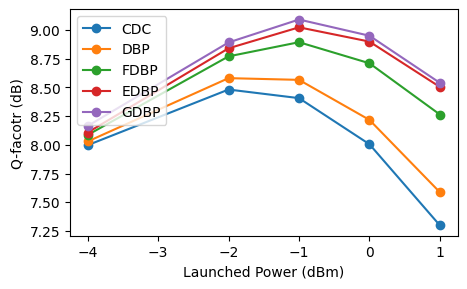

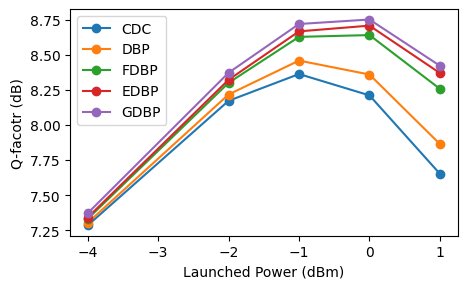

In [6]:
plot_lpvsq(q_ch1)
plot_lpvsq(q_ch4)

In [7]:
# Qs = np.load('source_data/snr_vs_lp.npz')
# Q = Qs['regular_taps']
# q_fewer_taps = Qs['few_taps']
Q = np.stack([q_ch1, q_ch2, q_ch3, q_ch4, q_ch5, q_ch6, q_ch7])
Q_opt = np.max(Q, axis=1)

(8.15, 9.5)

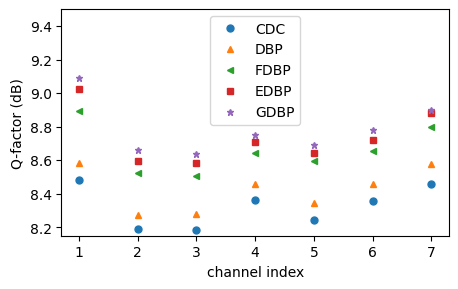

In [8]:
plt.figure(figsize=(5, 3), dpi=100)
CH = np.arange(1, 8)
plt.plot(CH, Q_opt[:, 0], 'o', label='CDC', markersize=5)
plt.plot(CH, Q_opt[:, 1], '^',  label='DBP', markersize=5)
plt.plot(CH, Q_opt[:, 2], '<',  label='FDBP', markersize=5)
plt.plot(CH, Q_opt[:, 3], 's',  label='EDBP', markersize=5)
plt.plot(CH, Q_opt[:, 4], '*',  label='GDBP', markersize=5)
plt.legend()
plt.xlabel('channel index')
plt.ylabel('Q-factor (dB)')
plt.ylim([8.15, 9.5])

## SNR v.s. launched power given limited taps

In [4]:
kwargs = {'save_subdirname': 'few_taps',
          'use_pretrained_params': False,
          'save_params': True,
          'model_init_kwargs': {'dtaps': 221, 'ntaps': 11, 'xi': 0.5}}

q_fewer_taps = sweep_channel(4, **kwargs)

sweeping dataset:   0%|          | 0/5 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

applying model:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

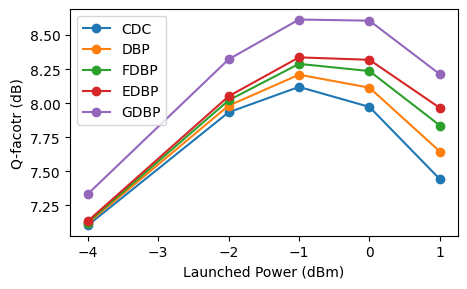

In [5]:
plot_lpvsq(q_fewer_taps)

In [19]:
# save source data
np.savez('source_data/snr_vs_lp.npz', regular_taps=Q, few_taps=q_fewer_taps)